# Severity prediction of traffic accident in the City of Seattle 

This project aimed at predicting collision severity based on a dataset hosted by the City of Seattle. In particular, the collisions with only property damage are labeled as less severe accidents; the ones involving injuries are deemed as severe. The dataset consists of features such as environmental conditions (<em>e.g.</em>, weather, road condition, and lighting condition), time of the accident, location information (<em>e.g.</em>, type of road), as well as the number of people and vehicles involved. Some of these factors, such as the number of cyclists in the recorded accidents, tend to be obvious features in predicting the severity of the collision, whereas some may be inevident (<em>e.g.</em>, particular road region) but bearing important insights into mitigating the severity of traffic accidents for the city.  

---
## Data
* Severity level of the collision: 
    1. property damage only; 
    2. with injury
* Three types of heuristical code (collision type, SDOT/state assigned code) used to describe the accident
* Other descriptive features
    * Categorical features, such as weather, road conditions, and address/junction type of the accident
    * Discrete but comparable features, <em>e.g.</em>, number of people/vehicles involved in the collision
    * Continuous features: time of the collision, and exact location 

## Models
* Tree models to predict the severity level of the accidents
    * Decision tree, 
    * random forest, 
    * xgboost, 
    * catboost
* Model complexity, early stopping - cross validation, hyperparameter tuning

## Highlights
What would lead to more severe collision?
* About 1/3 of all collisions are collisions with injury
* Accidents involving pedestrian or cyclist are more likely to be severe with injury
    * A certain lane segments tend to involve more cyclists in collision, which requires further investigations
* Left turn and angled collision is more likely to cause injury
* Severe accidents tend to happen at intersection
* Raining/wet road slightly elevates the probability of more severe accidents
* The latitude matters more in predicting severe collision (Seattle is bounded by water along longitude)

### Load libraries

In [163]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, r2_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, auc

from xgboost import XGBClassifier
import xgboost as xgb

from catboost import CatBoostClassifier, Pool
import shap

import datetime
from matplotlib import pyplot as plt
import seaborn as sns

In [352]:
pd.set_option('display.max_columns', None)

### Read and explore the dataset

In [441]:
df = pd.read_csv('Data-Collisions.csv', low_memory=False, parse_dates=["INCDATE"])
df["MONTH"] = df["INCDATE"].dt.month
df["YEAR"] = df["INCDATE"].dt.year

print(df.shape)
df.head()

(194673, 40)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE.1,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,MONTH,YEAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,5TH AVE NE AND NE 103RD ST,,NaN,2,Injury Collision,Angles,2,0,0,2,2013-03-27 00:00:00+00:00,3/27/2013 2:54:00 PM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Overcast,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N,3,2013
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N,NaN,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,2006-12-20 00:00:00+00:00,12/20/2006 6:55:00 PM,Mid-Block (not related to intersection),16,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ...",NaN,0,Raining,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N,12,2006
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST,NaN,NaN,1,Property Damage Only Collision,Parked Car,4,0,0,3,2004-11-18 00:00:00+00:00,11/18/2004 10:20:00 AM,Mid-Block (not related to intersection),14,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,0,Overcast,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N,11,2004
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,2ND AVE BETWEEN MARION ST AND MADISON ST,,NaN,1,Property Damage Only Collision,Other,3,0,0,3,2013-03-29 00:00:00+00:00,3/29/2013 9:26:00 AM,Mid-Block (not related to intersection),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N,3,2013
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,SWIFT AVE S AND SWIFT AV OFF RP,NaN,NaN,2,Injury Collision,Angles,2,0,0,2,2004-01-28 00:00:00+00:00,1/28/2004 8:04:00 AM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,0,Raining,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N,1,2004


In [4]:
df.columns
# Not sure what 'STATUS' is...

Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR', 'MONTH', 'YEAR'],
      dtype='object')

1    70.109877
2    29.890123
Name: SEVERITYCODE, dtype: float64


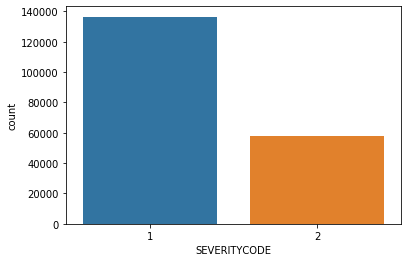

In [5]:
sns.countplot(df["SEVERITYCODE"])
print(df["SEVERITYCODE"].value_counts(normalize=True)*100)

In [353]:
# data type and cardinality for each feature
col_names = []
col_cardinality = []

for feature in df.columns:
    col_names.append(feature)
    cardinality = len(df[feature].unique())
    col_cardinality.append(cardinality)

pd.DataFrame([col_cardinality], columns=col_names)

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE.1,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,MONTH,YEAR,TIMEOFDAY
0,2,23564,23840,194673,194673,194673,194670,2,4,7615,24103,3,2,2,2,11,47,7,3,13,5985,162058,8,39,39,2,2,12,10,10,2,114933,2,64,63,1955,2198,2,12,17,316


In [435]:
df['EXCEPTRSNDESC'].unique()

array([nan,
       'Not Enough Information, or Insufficient Location Information'],
      dtype=object)

### Summary of features

#### Descriptive type of the collision
* COLLISIONTYPE(11), 
* SDOT_COLCODE(39); SDOT_COLDESC [code given to the collision by SDOT]; 
* ST_COLCODE(64); ST_COLDESC [State Collision Code];

* HITPARKEDCAR(2)
* PERSONCOUNT, PEDCOUNT, PEDCYLCOUNT, VEHCOUNT, 

#### Location related information
* X, Y(~24000): continous; 
* INTKEY(7615); LOCATION(24103); SEGLANEKEY(1955); CROSSWALKKEY(2198)

* ADDRTYPE(4); JUNCTIONTYPE(8)

#### Time of the collision
* INCDATE['MONTH', 'YEAR'], INCDTTM

#### Possible reasons leading to the collision
* INATTENTIONIND(2); UNDERINFL(2); SPEEDING(2); 

* PEDROWNOTGRNT(2) [Whether or not the pedestrian right of way was not granted]

* Other related conditions of the collision:
WEATHER(12); ROADCOND(10); LIGHTCOND(10)

#### unknown...
* STATUS (matched, unmatched)

### Distribution of severity among cardinality for each feature

In [606]:
def severity_dist_in_categ_feature(feature, figsize=[18,2], rotate_xticks=None):
    feature_by_severity_counts = df[[feature, "SEVERITYCODE"]].groupby([feature, 'SEVERITYCODE']).size().reset_index().rename(columns={0: 'count'})
    
#     plt.subplot(121); 
    plt.figure(figsize=figsize)
    sns.barplot(data=feature_by_severity_counts, x=feature, y='count', hue='SEVERITYCODE')
    if rotate_xticks is not None:
        plt.xticks(rotation=rotate_xticks)
#     xticks = plt.gca().get_xticklabels(True, minor=True)
#     plt.gca().set_xticklabels(xticks, rotation=20)

#     plt.subplot(122); df[[feature, "SEVERITYCODE"]].groupby(feature).apply(compute_severity_ratio).plot(); 
#     plt.ylabel('ratio')
#     plt.ylim([0,1]); plt.tight_layout(); plt.show()

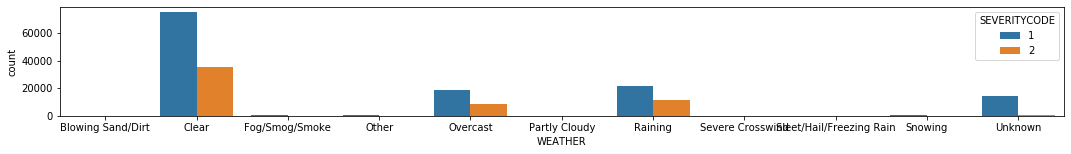

In [500]:
# df[[feature, "SEVERITYCODE"]].groupby([feature, "SEVERITYCODE"]).size()
# df.groupby(by=feature).size()  #if only interested in how feature is distributed

severity_dist_in_categ_feature('WEATHER')

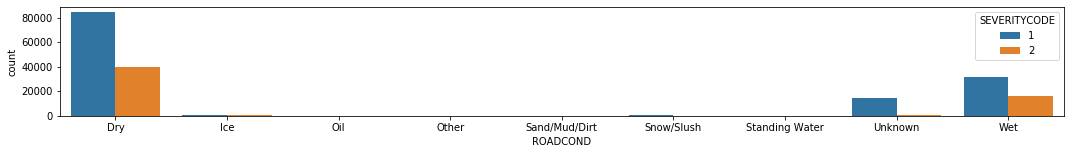

In [507]:
severity_dist_in_categ_feature('ROADCOND')

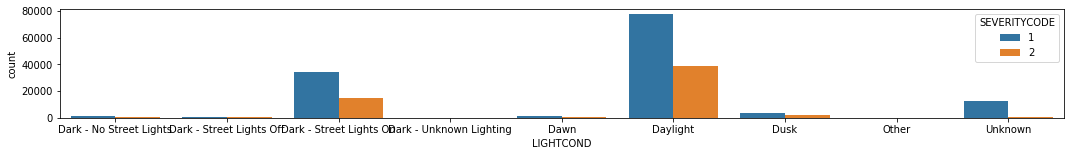

In [508]:
severity_dist_in_categ_feature('LIGHTCOND')

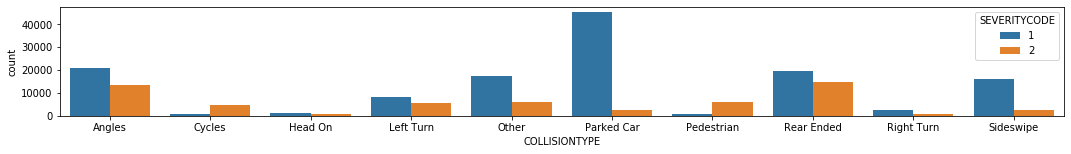

In [483]:
severity_dist_in_categ_feature('COLLISIONTYPE')

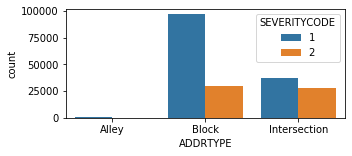

In [487]:
severity_dist_in_categ_feature('ADDRTYPE', figsize=[5, 2])

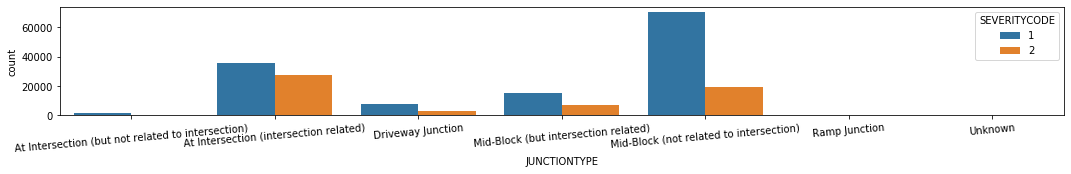

In [616]:
severity_dist_in_categ_feature('JUNCTIONTYPE', rotate_xticks=5)

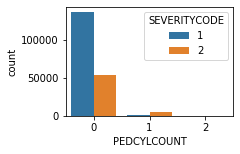

In [506]:
severity_dist_in_categ_feature('PEDCYLCOUNT', figsize=[3, 2])

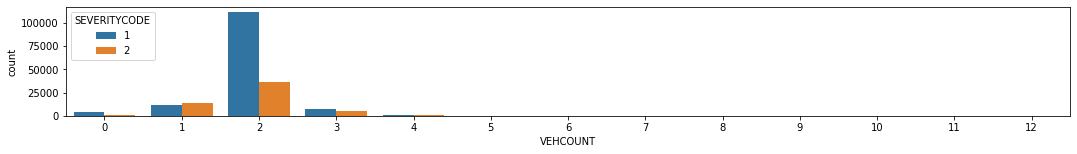

In [522]:
severity_dist_in_categ_feature('VEHCOUNT')

#### Locations

(-122.42793902636339, -122.22508217363658, 47.4762120096358, 47.7539189403642)

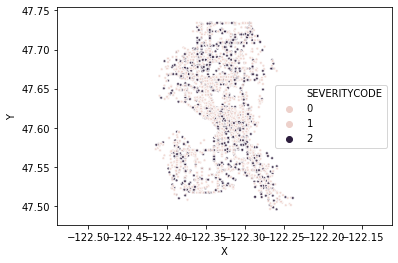

In [443]:
# plot the X/Y coordinates as a scatterplot where each dot is color-coded by the severity code.
# we randomly sample N (e.g. N=5000) to prevent from cluttering.
# X/Y values are clamped so that they are not affected by outliers

indices = np.arange(df.shape[0])
np.random.shuffle(indices)

g = sns.scatterplot(data=df.loc[indices[:5000], :], x='X', y='Y', hue='SEVERITYCODE', alpha=.8, s=8)

# df['Y'].quantile([.05, .95])  # the range of X,Y coordinates for location
g.set(xlim=df['X'].quantile([.05, .95]), ylim=df['Y'].quantile([.05, .95]))
plt.axis('equal')

In [597]:
df['X'].describe()

count    189339.000000
mean       -122.330548
std           0.028122
min        -122.382899
25%        -122.348673
50%        -122.330224
75%        -122.311937
max        -122.279829
Name: X, dtype: float64

In [444]:
# we can also plot the likelihood of severity on one axis at a time, at a coarser granularity

def binify_values(s, clamp_alpha=.05, bins=50):
    low, hi = s.quantile([clamp_alpha, 1.0 - clamp_alpha])
    s[s < low] = low
    s[s > hi] = hi
    
    return pd.cut(s, bins, labels=np.arange(bins))

In [676]:
def compute_severity_ratio(g):
    severity_counts = g.groupby('SEVERITYCODE').size()
    ratio = severity_counts.iloc[1] / severity_counts.iloc[0]
    return ratio


def severity_location_distribution(df, loc, nbin):
    # dataframe with binned loc and severity within that range
    df_loc = pd.DataFrame({loc: binify_values(df[loc], bins=nbin), 'SEVERITYCODE': df['SEVERITYCODE']})
    
    # count each severity level
    loc_by_severity_counts = df_loc.groupby([loc, 'SEVERITYCODE']).size().reset_index().rename(columns={0: 'count'})
    
    # visualize
    plt.figure(figsize=[6,4])
    plt.subplot(121); sns.barplot(data=loc_by_severity_counts, x=loc, y='count', hue='SEVERITYCODE')
    plt.subplot(122); df_loc.groupby(loc).apply(compute_severity_ratio).plot(); plt.ylabel('ratio'); plt.ylim([0,1])
    plt.tight_layout(); plt.show()

Percent of collision severity seems to depend on the verticial dimention, which may have to do with the extended highways.
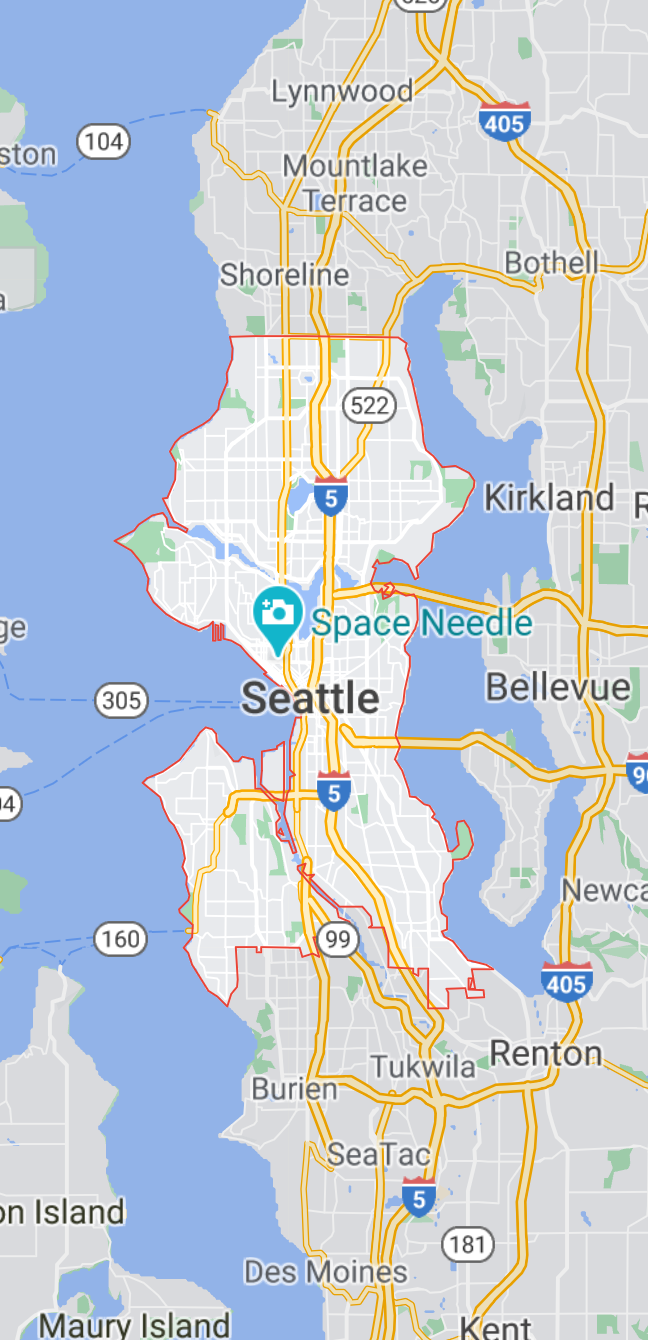
<!-- 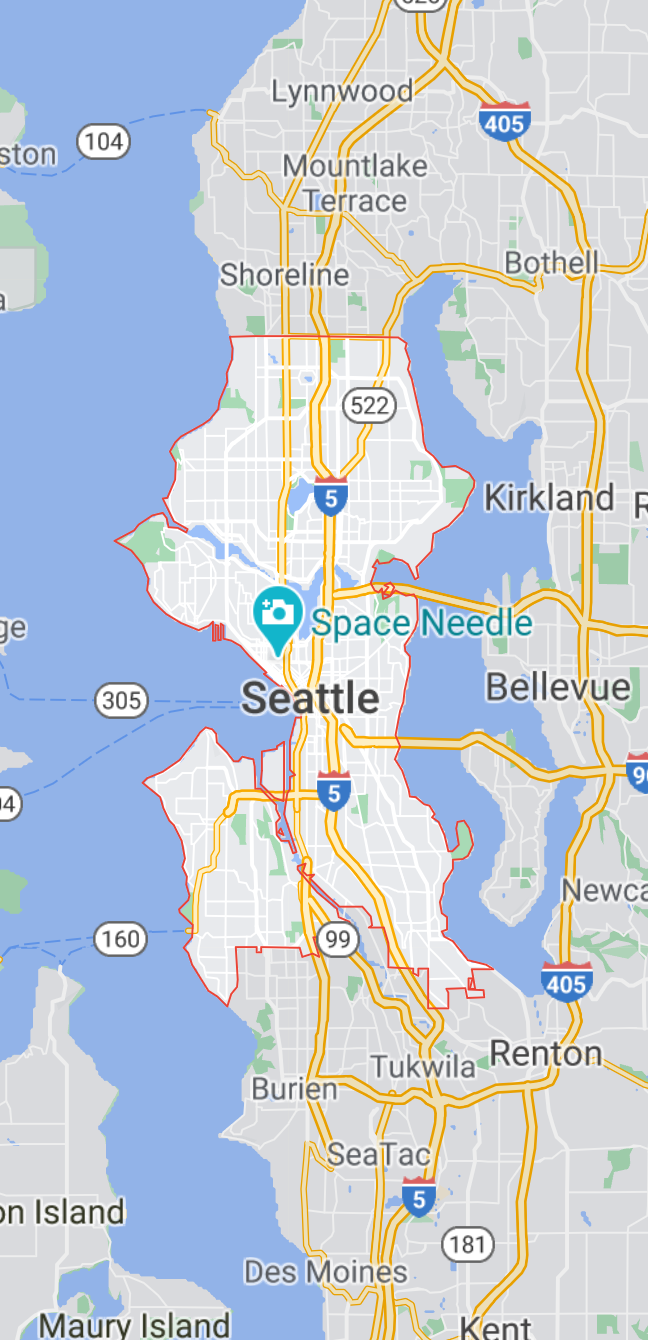 -->


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


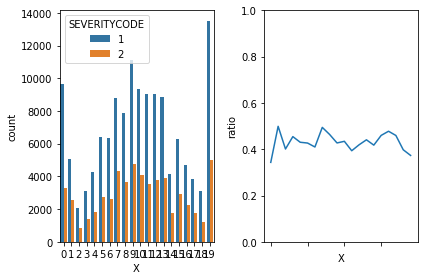

In [677]:
severity_location_distribution(df, 'X', nbin=20)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


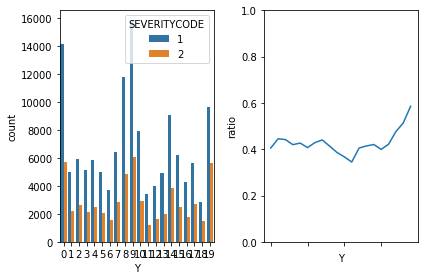

In [678]:
severity_location_distribution(df, 'Y', nbin=20)

#### Time of the day
For example, distribution of collision severity by month & time of the day

In [233]:
df['INCDTTM'] #'INCDTTM', 'INCDATE'

0           3/27/2013 2:54:00 PM
1          12/20/2006 6:55:00 PM
2         11/18/2004 10:20:00 AM
3           3/29/2013 9:26:00 AM
4           1/28/2004 8:04:00 AM
                   ...          
194668     11/12/2018 8:12:00 AM
194669     12/18/2018 9:14:00 AM
194670      1/19/2019 9:25:00 AM
194671      1/15/2019 4:48:00 PM
194672     11/30/2018 3:45:00 PM
Name: INCDTTM, Length: 194673, dtype: object

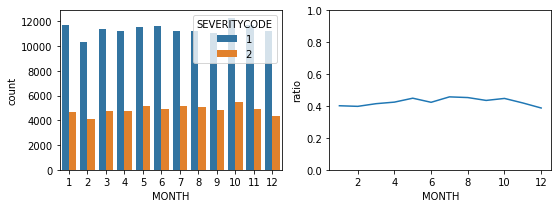

In [544]:
# df[['MONTH', "SEVERITYCODE"]].groupby(['MONTH', "SEVERITYCODE"]).size()
plt.figure(figsize=[8, 3])
loc_by_severity_counts = df[['MONTH', "SEVERITYCODE"]].groupby(['MONTH', 'SEVERITYCODE']).size().reset_index().rename(columns={0: 'count'})
plt.subplot(121); sns.barplot(data=loc_by_severity_counts, x='MONTH', y='count', hue='SEVERITYCODE')
plt.subplot(122); df[['MONTH', "SEVERITYCODE"]].groupby('MONTH').apply(compute_severity_ratio).plot(); plt.ylabel('ratio')
plt.ylim([0,1]); plt.tight_layout(); plt.show()

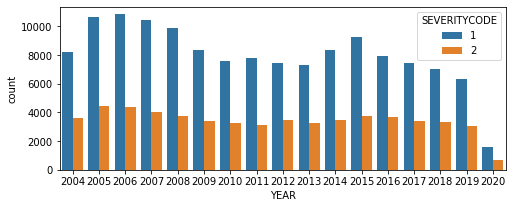

In [664]:
severity_dist_in_categ_feature('YEAR', figsize=[8, 3])

Use strptime to parse: df['INCDTTM'], and combine hour and minute to form the new fearture: time of the day 

In [612]:
def for_dtime(x):
    for time_format in ['%m/%d/%Y %I:%M:%S %p','%m/%d/%Y']: 
        try: 
            incdttm = datetime.datetime.strptime(x, time_format)
            break
        except ValueError:
            pass
    return incdttm.hour+incdttm.minute/6

df['TIMEOFDAY'] = df["INCDTTM"].apply(for_dtime)

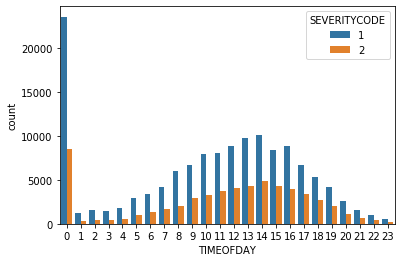

In [665]:
hour = pd.cut(df['TIMEOFDAY'], bins=24, labels=np.arange(24))
hour_severe = pd.concat([hour,df['SEVERITYCODE']], axis=1)
hour_by_severity_counts = hour_severe.groupby(['TIMEOFDAY', 'SEVERITYCODE']).size().reset_index().rename(columns={0: 'count'})
sns.barplot(data=hour_by_severity_counts, x='TIMEOFDAY', y='count', hue='SEVERITYCODE')

Note that the accidents without exact time in file is labeled as 0 hour, which results in the peak at 0.

### Data preprocess 

#### Data clean up
Mostly for fillna & missing data, and to combine same meaning labels
* UNDERINFL

In [617]:
# e.g., UNDERINFL, four categories, however, [0,1] & [N,Y] indicate likewise
def for_UNDERINFL(x):
    if x in ['Y','1']:
        return 1
    elif x in ['N','0']:
        return 0
    else:
        return x
    
df["UNDERINFL"] = df["UNDERINFL"].apply(for_UNDERINFL)

In [618]:
df['UNDERINFL'].fillna(0, inplace=True)

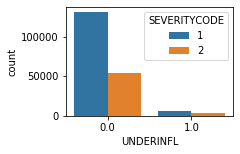

In [619]:
severity_dist_in_categ_feature('UNDERINFL', figsize=[3, 2])

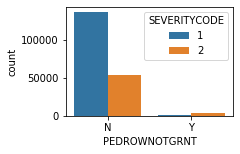

In [620]:
df['PEDROWNOTGRNT'].fillna('N', inplace=True)
severity_dist_in_categ_feature('PEDROWNOTGRNT', figsize=[3,2])

Although the total number of collisions involving the pedestrian right of way was not granted ("PEDROWNOTGRNT") is fairly small, the percent of being a severe accident is high. 

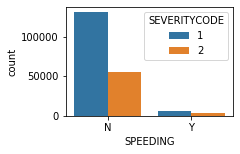

In [621]:
df['SPEEDING'].fillna('N', inplace=True)
severity_dist_in_categ_feature('SPEEDING', figsize=[3,2])

* Location X, Y

In [7]:
# location
loc_y = binify_values(df['Y'], bins=50)
loc_y = loc_y.cat.add_categories(-99)  # fill missing data with -99
loc_y.fillna(-99, inplace=True)
loc_x = binify_values(df['X'], bins=50)
loc_x = loc_x.cat.add_categories(-99)  # fill missing data with -99
loc_x.fillna(-99, inplace=True)

/Users/chengqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/chengqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [162]:
df['Y'].describe()

count    194673.000000
mean         47.619543
std           0.055382
min          47.495573
25%          47.578153
50%          47.616802
75%          47.662569
max          47.734142
Name: Y, dtype: float64

In [622]:
# missing data in tree models: use a special value to fill in (instead of mean), 
# so the model can treat these missing values differently

df['X'].fillna(0, inplace=True)
df['Y'].fillna(0, inplace=True)

In [623]:
df['INTKEY'].fillna(0, inplace=True)
df['INTKEY'] = df['INTKEY'].astype(int)

#### Ordinal encoding of categorical features

In [169]:
def categ_to_ordinal(df, feature='COLLISIONTYPE'):
    enc = preprocessing.OrdinalEncoder(dtype=np.int)
    col = df[feature].fillna('').values.reshape(-1, 1)
    ordinal_encoded = enc.fit_transform(col)

    return pd.Series(ordinal_encoded.reshape(-1), name=feature)

In [190]:
categ_to_ordinal(df)

0          1
1         10
2          6
3          5
4          1
          ..
194668     3
194669     8
194670     4
194671     2
194672     8
Name: COLLISIONTYPE, Length: 194673, dtype: int64

#### One hot encoding of categorical features

In [624]:
def categ_to_one_hot(df, feature='ROADCOND'):
    enc = preprocessing.OneHotEncoder()
    # fill in None, to reshape to 2D (column)
    col = df[feature].fillna("").values.reshape(-1, 1)
    # one hot encode
    one_hot_encoded = enc.fit_transform(col).toarray()
    
    # to a data frame
    df_cols = {}
    for col_index, cat in enumerate(enc.categories_[0]):
        df_cols[feature + '_' + cat] = one_hot_encoded[:, col_index]

    return pd.DataFrame(df_cols)

In [625]:
df_addrtype = categ_to_one_hot(df, feature='ADDRTYPE')
df_collisiontype = categ_to_one_hot(df, feature='COLLISIONTYPE')
df_junctiontype = categ_to_one_hot(df, feature='JUNCTIONTYPE')

df_weather = categ_to_one_hot(df, feature='WEATHER')
df_roadcond = categ_to_one_hot(df, feature='ROADCOND')
df_lightcond = categ_to_one_hot(df, feature='LIGHTCOND')

In [71]:
df['WEATHER'].unique()

array(['Overcast', 'Raining', 'Clear', nan, 'Unknown', 'Other', 'Snowing',
       'Fog/Smog/Smoke', 'Sleet/Hail/Freezing Rain', 'Blowing Sand/Dirt',
       'Severe Crosswind', 'Partly Cloudy'], dtype=object)

In [626]:
df_sdotcold=categ_to_one_hot(df, feature='SDOT_COLDESC')

In [627]:
df_stcode =categ_to_one_hot(df, feature='ST_COLCODE')

#### What about "correlation" (measure of association) between categorical variables?
Cramer's V (ref: https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9)

In [530]:
import scipy.stats as ss

def cramers_v(x, y):
    '''Calculate measure of association using cramers'v (https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V). 
    Adapted from https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
    
    Parameters
    -----------
    x: series with variable values.
    y: another series to be compared with x.
    
    Returns
    -----------
    corr: the measure of association between x and y
    
    '''
    confusion_matrix = pd.crosstab(x,y)   # calculate frequency table of x, y
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
                                          # chi-square statistics indicating if the frequencies are dependent 
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [587]:
# remove nan in data
df['INATTENTIONIND'].fillna('N', inplace=True)
df['ADDRTYPE'].fillna('Unknown', inplace=True)
df['INTKEY'].fillna(0, inplace=True)

columns_of_interest = ['SEVERITYCODE', 'COLLISIONTYPE', 'SDOT_COLCODE', 'ST_COLCODE', 
                       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT',
                       'INTKEY', 'LOCATION', 'SEGLANEKEY', 'CROSSWALKKEY', 'ADDRTYPE', 'JUNCTIONTYPE', 
                       'MONTH', 'YEAR',
                       'INATTENTIONIND', 'UNDERINFL', 'SPEEDING', 'PEDROWNOTGRNT',
                       'WEATHER', 'ROADCOND', 'LIGHTCOND']
cramerv_mtx = np.zeros([len(columns_of_interest), len(columns_of_interest)])
for x in range(len(columns_of_interest)):
    for y in range(x+1, len(columns_of_interest)):
        cramerv_mtx[x, y] = cramers_v(df[columns_of_interest[x]], df[columns_of_interest[y]])

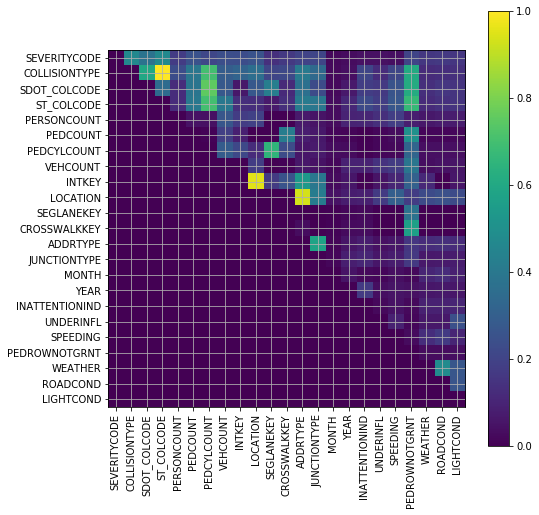

In [595]:
plt.figure(figsize=[8,8])
plt.imshow(cramerv_mtx, vmin=0, vmax=1); plt.colorbar()
plt.gca().set_yticks(np.arange(len(columns_of_interest))); 
plt.gca().set_yticklabels(columns_of_interest);

plt.gca().set_xticks(np.arange(len(columns_of_interest))); 
plt.gca().set_xticklabels(columns_of_interest, rotation=90);
plt.grid()

Data observations:
* COLLISIONTYPE(11) and ST_COLCODE(64) are highly associated; Also, all three codes seem to associated with PERSONCOUNT, PEDCOUNT, and whether PED has right of way, SPEEDING or INATTENTION - these could be major heuristic features for the codes
* Compared to other features, the 3 codes are better associated with SEVERITY level
* INTKEY, LOCATION, and ADDRTYPE (JUNCTIONTYPE) are associated
* WEATHER is expected to be associated with ROADCOND
* PEDCYLCOUNT co-occurred with some SEGLANEKEY - which may suggest some seglane can be particular dangerous for cyclist, further investigation is needed

In [600]:
df['SEGLANEKEY'].unique()

array([    0,  6855, 25242, ..., 11583, 10319, 45880])

### Decision tree model

In [628]:
df_preprocessed = pd.concat([df_addrtype, df_collisiontype, df_junctiontype, 
                             df_weather, df_roadcond, df_lightcond, 
                             df_sdotcold, df_stcode, 
                             df[['PERSONCOUNT', 'PEDCYLCOUNT', 'PEDCOUNT', 'VEHCOUNT', 'UNDERINFL', 
                                 'X', 'Y', 'TIMEOFDAY', 'MONTH', 'YEAR']] 
                             ], axis=1) # loc_y.astype(int), loc_x.astype(int)
# df_preprocessed = pd.concat([df['PEDCOUNT'], df['PEDCYLCOUNT'], df['VEHCOUNT'], df_sdotcold], axis=1)
# df_preprocessed = pd.concat([df_collisiontype, df['UNDERINFL']], axis=1)
df_preprocessed

,ADDRTYPE_Alley,ADDRTYPE_Block,ADDRTYPE_Intersection,ADDRTYPE_Unknown,COLLISIONTYPE_,COLLISIONTYPE_Angles,COLLISIONTYPE_Cycles,COLLISIONTYPE_Head On,COLLISIONTYPE_Left Turn,COLLISIONTYPE_Other,COLLISIONTYPE_Parked Car,COLLISIONTYPE_Pedestrian,COLLISIONTYPE_Rear Ended,COLLISIONTYPE_Right Turn,COLLISIONTYPE_Sideswipe,JUNCTIONTYPE_,JUNCTIONTYPE_At Intersection (but not related to intersection),JUNCTIONTYPE_At Intersection (intersection related),JUNCTIONTYPE_Driveway Junction,JUNCTIONTYPE_Mid-Block (but intersection related),JUNCTIONTYPE_Mid-Block (not related to intersection),JUNCTIONTYPE_Ramp Junction,JUNCTIONTYPE_Unknown,WEATHER_,WEATHER_Blowing Sand/Dirt,WEATHER_Clear,WEATHER_Fog/Smog/Smoke,WEATHER_Other,WEATHER_Overcast,WEATHER_Partly Cloudy,WEATHER_Raining,WEATHER_Severe Crosswind,WEATHER_Sleet/Hail/Freezing Rain,WEATHER_Snowing,WEATHER_Unknown,ROADCOND_,ROADCOND_Dry,ROADCOND_Ice,ROADCOND_Oil,ROADCOND_Other,ROADCOND_Sand/Mud/Dirt,ROADCOND_Snow/Slush,ROADCOND_Standing Water,ROADCOND_Unknown,ROADCOND_Wet,LIGHTCOND_,LIGHTCOND_Dark - No Street Lights,LIGHTCOND_Dark - Street Lights Off,LIGHTCOND_Dark - Street Lights On,LIGHTCOND_Dark - Unknown Lighting,LIGHTCOND_Dawn,LIGHTCOND_Daylight,LIGHTCOND_Dusk,LIGHTCOND_Other,LIGHTCOND_Unknown,SDOT_COLDESC_DRIVERLESS VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,SDOT_COLDESC_DRIVERLESS VEHICLE RAN OFF ROAD - NO COLLISION,SDOT_COLDESC_DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE FRONT END AT ANGLE,SDOT_COLDESC_DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE LEFT SIDE AT ANGLE,SDOT_COLDESC_DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE LEFT SIDE SIDESWIPE,SDOT_COLDESC_DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE REAR END,SDOT_COLDESC_DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE RIGHT SIDE AT ANGLE,SDOT_COLDESC_DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE RIGHT SIDE SIDESWIPE,SDOT_COLDESC_DRIVERLESS VEHICLE STRUCK OBJECT IN ROADWAY,SDOT_COLDESC_DRIVERLESS VEHICLE STRUCK PEDESTRIAN,SDOT_COLDESC_MOTOR VEHCILE STRUCK PEDESTRIAN,SDOT_COLDESC_MOTOR VEHICLE OVERTURNED IN ROAD,SDOT_COLDESC_MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,SDOT_COLDESC_MOTOR VEHICLE RAN OFF ROAD - NO COLLISION,"SDOT_COLDESC_MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE","SDOT_COLDESC_MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE AT ANGLE","SDOT_COLDESC_MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE SIDESWIPE","SDOT_COLDESC_MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END","SDOT_COLDESC_MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE AT ANGLE","SDOT_COLDESC_MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE SIDESWIPE",SDOT_COLDESC_MOTOR VEHICLE STRUCK OBJECT IN ROAD,"SDOT_COLDESC_MOTOR VEHICLE STRUCK PEDALCYCLIST, FRONT END AT ANGLE","SDOT_COLDESC_MOTOR VEHICLE STRUCK PEDALCYCLIST, LEFT SIDE SIDESWIPE","SDOT_COLDESC_MOTOR VEHICLE STRUCK PEDALCYCLIST, REAR END","SDOT_COLDESC_MOTOR VEHICLE STRUCK PEDALCYCLIST, RIGHT SIDE SIDESWIPE",SDOT_COLDESC_MOTOR VEHICLE STRUCK TRAIN,SDOT_COLDESC_NOT ENOUGH INFORMATION / NOT APPLICABLE,SDOT_COLDESC_PEDALCYCLIST OVERTURNED IN ROAD,SDOT_COLDESC_PEDALCYCLIST RAN OFF ROAD - HIT FIXED OBJECT,SDOT_COLDESC_PEDALCYCLIST STRUCK MOTOR VEHICLE FRONT END AT ANGLE,SDOT_COLDESC_PEDALCYCLIST STRUCK MOTOR VEHICLE LEFT SIDE AT ANGLE,SDOT_COLDESC_PEDALCYCLIST STRUCK MOTOR VEHICLE LEFT SIDE SIDESWIPE,SDOT_COLDESC_PEDALCYCLIST STRUCK MOTOR VEHICLE REAR END,SDOT_COLDESC_PEDALCYCLIST STRUCK MOTOR VEHICLE RIGHT SIDE AT ANGLE,SDOT_COLDESC_PEDALCYCLIST STRUCK MOTOR VEHICLE RIGHT SIDE SIDESWIPE,SDOT_COLDESC_PEDALCYCLIST STRUCK OBJECT IN ROAD,SDOT_COLDESC_PEDALCYCLIST STRUCK PEDALCYCLIST FRONT END AT ANGLE,SDOT_COLDESC_PEDALCYCLIST STRUCK PEDALCYCLIST REAR END,SDOT_COLDESC_PEDALCYCLIST STRUCK PEDESTRIAN,ST_COLCODE_,ST_COLCODE_,ST_COLCODE_0,ST_COLCODE_1,ST_COLCODE_10,ST_COLCODE_11,ST_COLCODE_12,ST_COLCODE_13,ST_COLCODE_14,ST_COLCODE_15,ST_COLCODE_16,ST_COLCODE_17,ST_COLCODE_18,ST_COLCODE_19,ST_COLCODE_2,ST_COLCODE_20,ST_COLCODE_21,ST_COLCODE_22,ST_COLCODE_23,ST_COLCODE_24,ST_COLCODE_25,ST_COLCODE_26,ST_COLCODE_27,ST_COLCODE_28,ST_COLCODE_29,ST_COLCODE_3,S

In [629]:
X_train, X_test, y_train, y_test = train_test_split(
    df_preprocessed, df['SEVERITYCODE'], test_size=0.2, random_state=1)
tree = DecisionTreeClassifier(criterion="gini", max_depth = 10, class_weight=None).fit(X_train, y_train)
# class_weight:default-None; 'balanced' means to adjust weights based on label distribution 
#             (inverse to the proportion, so more leads to less important)
# max_features: if None, all features are considered 

tree_pred = tree.predict(X_test)
tree_pred

print('Score:',accuracy_score(tree_pred, y_test))
print('F1-Score:',f1_score(tree_pred, y_test))
print('Confusion Martix:')
print(confusion_matrix(y_test, tree_pred))
print('')
print('Classification Report:')
print(classification_report(y_test, tree_pred))

Score: 0.7587517657634519
F1-Score: 0.8465872899211132
Confusion Martix:
[[25917  1442]
 [ 7951  3625]]

Classification Report:
              precision    recall  f1-score   support

           1       0.77      0.95      0.85     27359
           2       0.72      0.31      0.44     11576

    accuracy                           0.76     38935
   macro avg       0.74      0.63      0.64     38935
weighted avg       0.75      0.76      0.72     38935



0.7916115443502961


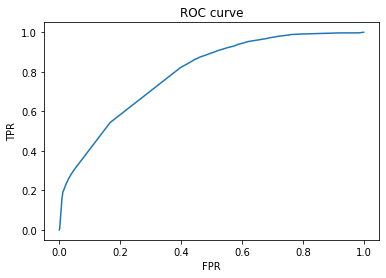

In [630]:
predictions = tree.predict_proba(X_test)
print(roc_auc_score(y_test, predictions[:,1]))

fpr, tpr, _ = roc_curve(y_test-1, predictions[:,1])
# fpr_0, tpr_0, _ = roc_curve((3-y_test)-1, predictions[:,0])

plt.clf()
plt.plot(fpr, tpr)
# plt.plot(fpr_0, tpr_0)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

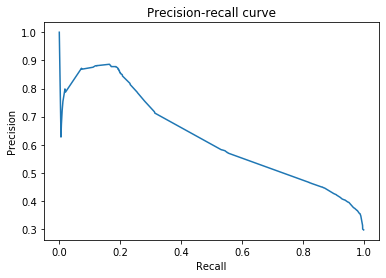

pr auc:0.6266400146229061


In [631]:
# since the data is also imbalance (more non-severe than yes), look at Precision-Recall curve as well
precision, recall, _ = precision_recall_curve(y_test-1, predictions[:,1])
plt.clf()
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve')
plt.show()

print('pr auc:' + str(auc(recall, precision)))

Text(0, 0.5, 'Feature Importance Score')

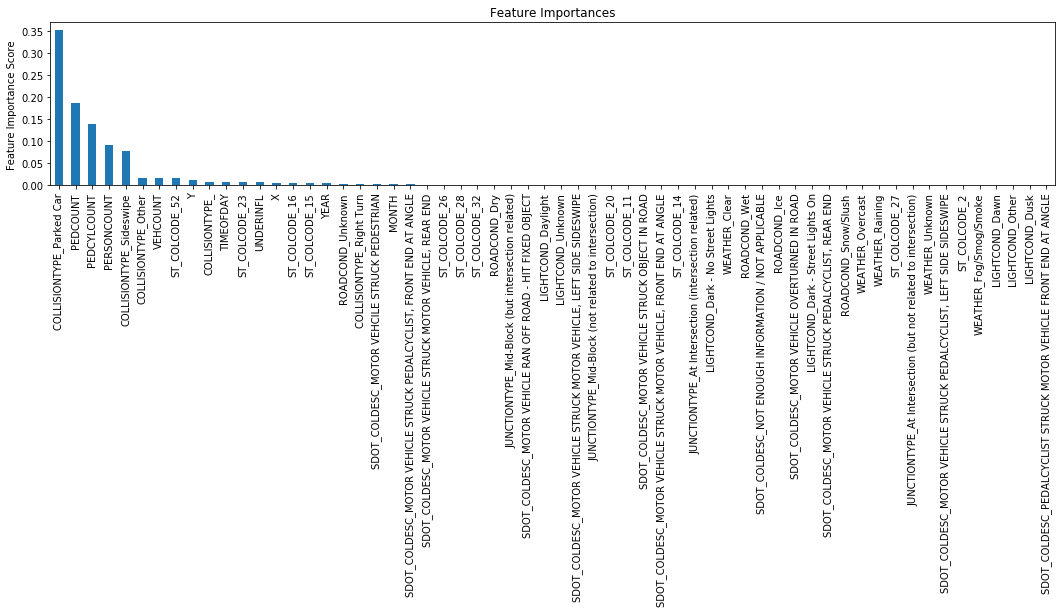

In [637]:
pd.Series(tree.feature_importances_, index=df_preprocessed.columns)
# the importance decided based on the information gain achieved based on the feature at splits
#
plt.figure(figsize=[18,3])
feat_imp = pd.Series(tree.feature_importances_, index=df_preprocessed.columns).sort_values(ascending=False)
feat_imp[:60].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

ST_COLCODE_52: vehicle overturned

ST_COLCODE_23/15/16: same direction (left, right turn, or other)

In [91]:
tree.tree_.max_depth

15

#### Parameter tuning
cross-validated grid-search over a parameter grid

In [341]:
decision_tree_model = DecisionTreeClassifier(random_state=0)
# cross_val_score(clf, df_preprocessed, df['SEVERITYCODE'], cv=10)
#
## df_collisiontype by itself can push the cross_val_score to ~.75;
## df['PEDCYLCOUNT'] can do ~.72; df['PEDCOUNT'] is ~.73; df['VEHCOUNT'] is ~.71; these three combined reaches .75;
#
parameters = {'criterion':('gini', 'entropy'), 'max_depth':[5, 10, 15]}
clf = GridSearchCV(decision_tree_model, parameters, scoring={'roc': 'roc_auc', 'f1': 'f1'}, refit='roc')
# cv: default None, which is 5-fold
# return_train_score: if True, besides test score, also return train score. default is False

clf.fit(X_train, y_train)


GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [5, 10, 15]},
             

In [129]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_f1',
 'mean_test_roc',
 'param_criterion',
 'param_max_depth',
 'params',
 'rank_test_f1',
 'rank_test_roc',
 'split0_test_f1',
 'split0_test_roc',
 'split1_test_f1',
 'split1_test_roc',
 'split2_test_f1',
 'split2_test_roc',
 'split3_test_f1',
 'split3_test_roc',
 'split4_test_f1',
 'split4_test_roc',
 'std_fit_time',
 'std_score_time',
 'std_test_f1',
 'std_test_roc']

In [342]:
clf.cv_results_['mean_test_roc']

array([0.77203914, 0.79057567, 0.77155959, 0.77234216, 0.79041011,
       0.77160324])

In [343]:
# clf.best_estimator_
# clf.best_score_
clf.best_params_

{'criterion': 'gini', 'max_depth': 10}

### Random forest

In [638]:
forest = RandomForestClassifier(n_estimators=100,criterion="gini", max_depth = 15, 
                                class_weight=None).fit(X_train, y_train)
# max_features: default - 'auto', sqrt(n_features)
# bootstrap: bool, default=True
# max_samples: int or float, default=None (when bootstrap is TRUE, None - draw same number of samples)
#
forest_pred = forest.predict(X_test)
forest_pred

print('Score:',accuracy_score(forest_pred, y_test))
print('F1-Score:',f1_score(forest_pred, y_test))
print('Confusion Martix:')
print(confusion_matrix(y_test, forest_pred))
print('')
print('Classification Report:')
print(classification_report(y_test, forest_pred))

predictions = forest.predict_proba(X_test)
print('auc: ' + str(roc_auc_score(y_test, predictions[:,1])))

precision, recall, _ = precision_recall_curve(y_test-1, predictions[:,1])
print('pr auc: ' + str(auc(recall, precision)))

Score: 0.7601386926929498
F1-Score: 0.8508456710267835
Confusion Martix:
[[26637   722]
 [ 8617  2959]]

Classification Report:
              precision    recall  f1-score   support

           1       0.76      0.97      0.85     27359
           2       0.80      0.26      0.39     11576

    accuracy                           0.76     38935
   macro avg       0.78      0.61      0.62     38935
weighted avg       0.77      0.76      0.71     38935

auc: 0.8036196293805017
pr auc: 0.6445483678873156


Text(0, 0.5, 'Feature Importance Score')

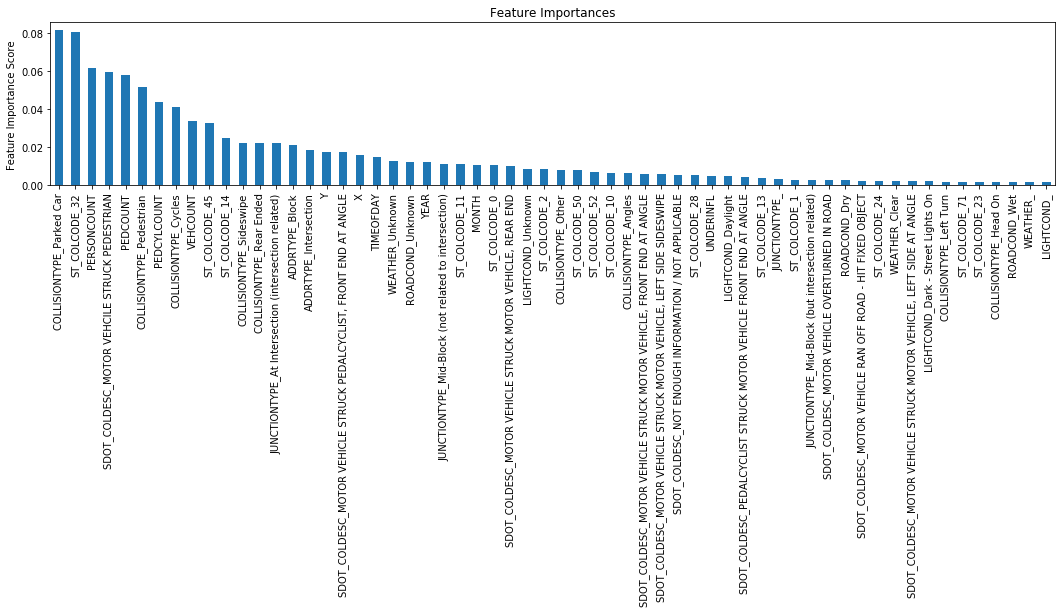

In [642]:
plt.figure(figsize=[18,3])
rdforest_feature = pd.Series(forest.feature_importances_, index=df_preprocessed.columns).sort_values(ascending=False)
rdforest_feature[:60].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [62]:
forest.n_features_

101

#### Parameter tuning 

In [149]:
forest_model = RandomForestClassifier(random_state=0)

parameters = {'n_estimators':[50, 100, 150], 'max_depth':[3, 6, 9, 12]}
clf = GridSearchCV(forest_model, parameters, scoring={'roc': 'roc_auc', 'f1': 'f1'}, refit='roc')
# cv: default None, which is 5-fold
# return_train_score: if True, besides test score, also return train score. default is False

clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=0,
                                

In [150]:
print(clf.best_params_)
print(clf.best_score_)
print(clf.cv_results_['params'])
clf.cv_results_['mean_test_roc']

{'max_depth': 12, 'n_estimators': 150}
0.7994482300331068
[{'max_depth': 3, 'n_estimators': 50}, {'max_depth': 3, 'n_estimators': 100}, {'max_depth': 3, 'n_estimators': 150}, {'max_depth': 6, 'n_estimators': 50}, {'max_depth': 6, 'n_estimators': 100}, {'max_depth': 6, 'n_estimators': 150}, {'max_depth': 9, 'n_estimators': 50}, {'max_depth': 9, 'n_estimators': 100}, {'max_depth': 9, 'n_estimators': 150}, {'max_depth': 12, 'n_estimators': 50}, {'max_depth': 12, 'n_estimators': 100}, {'max_depth': 12, 'n_estimators': 150}]


array([0.76480333, 0.76791014, 0.770238  , 0.78727624, 0.78867528,
       0.78857367, 0.79459342, 0.79533269, 0.79521104, 0.79889862,
       0.79933072, 0.79944823])

### xgboost

In [643]:
dtrain = xgb.DMatrix(X_train, label=y_train-1)
dtest = xgb.DMatrix(X_test, label=y_test-1)

param = {'max_depth': 5, 'eta': .1, 'objective': 'binary:logistic', 'min_child_weight': 1}
param['nthread'] = 4
param['eval_metric'] = 'auc'  # if multiple, the last one would be used for early stopping evaluation

evallist = [(dtrain, 'train'), (dtest, 'eval')]  # to be able to see both train/val errors, however, eval_auc would be used for early stopping

num_round = 50
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=5) 
# if the metric result [eval_auc] do not improve for N rounds, model should stop training

ypred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)  # use the best model
print('auc: ' + str(roc_auc_score(y_test-1, ypred)))

[0]	train-auc:0.77280	eval-auc:0.77207
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 5 rounds.
[1]	train-auc:0.77288	eval-auc:0.77214
[2]	train-auc:0.77288	eval-auc:0.77221
[3]	train-auc:0.77314	eval-auc:0.77240
[4]	train-auc:0.77318	eval-auc:0.77244
[5]	train-auc:0.78036	eval-auc:0.77930
[6]	train-auc:0.78075	eval-auc:0.77971
[7]	train-auc:0.78323	eval-auc:0.78241
[8]	train-auc:0.78332	eval-auc:0.78237
[9]	train-auc:0.78642	eval-auc:0.78485
[10]	train-auc:0.78917	eval-auc:0.78733
[11]	train-auc:0.79026	eval-auc:0.78804
[12]	train-auc:0.79058	eval-auc:0.78861
[13]	train-auc:0.79230	eval-auc:0.78988
[14]	train-auc:0.79287	eval-auc:0.79028
[15]	train-auc:0.79429	eval-auc:0.79187
[16]	train-auc:0.79442	eval-auc:0.79203
[17]	train-auc:0.79602	eval-auc:0.79370
[18]	train-auc:0.79688	eval-auc:0.79428
[19]	train-auc:0.79720	eval-auc:0.79471
[20]	train-auc:0.79783	eval-auc:0.79519
[21]	train-auc:0.79799	eval-au

In [204]:
ypred

array([0.24655373, 0.6893549 , 0.00295407, ..., 0.5131798 , 0.33869988,
       0.6005166 ], dtype=float32)

In [73]:
# xgb.plot_importance(bst)

Text(0, 0.5, 'Feature Importance Score')

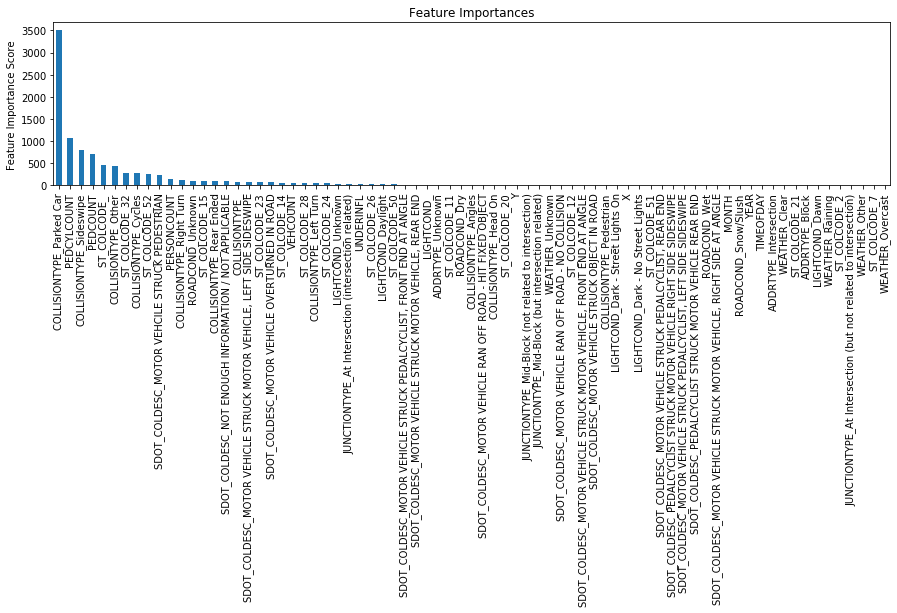

In [644]:
# bst.get_fscore()
bst_importance = bst.get_score(importance_type='gain')
# {k: v for k, v in sorted(bst_importance.items(), key=lambda item: item[1], reverse=True)}

plt.figure(figsize=[15,3])
feat_imp = pd.Series(bst_importance).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [232]:
# xgb.plot_tree(bst, num_trees=2)

In [217]:
# use a different grammar - sklearn wrapper for XGBoost
model = XGBClassifier(importance_type='gain', 
              learning_rate=0.5, max_depth=5,
              min_child_weight=1, 
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0)
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["auc"], eval_set=eval_set, early_stopping_rounds=5, verbose=True)

ypred = model.predict_proba(X_test, ntree_limit=model.best_ntree_limit)
print('auc: ' + str(roc_auc_score(y_test-1, ypred[:,1])))

[0]	validation_0-auc:0.77187
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.77924
[2]	validation_0-auc:0.78469
[3]	validation_0-auc:0.78992
[4]	validation_0-auc:0.79180
[5]	validation_0-auc:0.79374
[6]	validation_0-auc:0.79654
[7]	validation_0-auc:0.79725
[8]	validation_0-auc:0.79804
[9]	validation_0-auc:0.79985
[10]	validation_0-auc:0.80039
[11]	validation_0-auc:0.80085
[12]	validation_0-auc:0.80119
[13]	validation_0-auc:0.80126
[14]	validation_0-auc:0.80157
[15]	validation_0-auc:0.80182
[16]	validation_0-auc:0.80208
[17]	validation_0-auc:0.80214
[18]	validation_0-auc:0.80208
[19]	validation_0-auc:0.80254
[20]	validation_0-auc:0.80284
[21]	validation_0-auc:0.80284
[22]	validation_0-auc:0.80278
[23]	validation_0-auc:0.80272
[24]	validation_0-auc:0.80271
[25]	validation_0-auc:0.80267
[26]	validation_0-auc:0.80269
Stopping. Best iteration:
[21]	validation_0-auc:0.80284

auc: 0.8028400132407228


#### Hyperparameter Tuning

In [220]:
model = xgb.XGBClassifier()
param_dist = {"max_depth": [5,10],
              "min_child_weight" : [1,5,10],
              "n_estimators": [200],
              "learning_rate": [0.1,1]}
# min_child_weight controls model complexity, similar to # of instance in leaf (though not exact)
#
grid_search = GridSearchCV(model, param_grid=param_dist, cv=3, verbose=10, n_jobs=-1)
eval_set = [(X_test, y_test)]
grid_search.fit(X_train, y_train, eval_set=eval_set, eval_metric=["auc"], early_stopping_rounds=5)

grid_search.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  36 | elapsed:  1.8min remaining:  5.5min
[Parallel(n_jobs=-1)]: Done  13 out of  36 | elapsed:  2.0min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done  17 out of  36 | elapsed:  2.1min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  21 out of  36 | elapsed:  2.2min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed:  2.2min remaining:   58.9s
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:  2.3min remaining:   33.0s
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed:  2.3min remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  3.0min finished


[0]	validation_0-auc:0.77187
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.77190
[2]	validation_0-auc:0.77208
[3]	validation_0-auc:0.77204
[4]	validation_0-auc:0.77208
[5]	validation_0-auc:0.77894
[6]	validation_0-auc:0.77941
[7]	validation_0-auc:0.78196
[8]	validation_0-auc:0.78193
[9]	validation_0-auc:0.78194
[10]	validation_0-auc:0.78371
[11]	validation_0-auc:0.78602
[12]	validation_0-auc:0.78862
[13]	validation_0-auc:0.78902
[14]	validation_0-auc:0.78929
[15]	validation_0-auc:0.79061
[16]	validation_0-auc:0.79119
[17]	validation_0-auc:0.79141
[18]	validation_0-auc:0.79180
[19]	validation_0-auc:0.79182
[20]	validation_0-auc:0.79221
[21]	validation_0-auc:0.79235
[22]	validation_0-auc:0.79291
[23]	validation_0-auc:0.79336
[24]	validation_0-auc:0.79355
[25]	validation_0-auc:0.79361
[26]	validation_0-auc:0.79372
[27]	validation_0-auc:0.79449
[28]	validation_0-auc:0.79474
[29]	validation_0-auc:0.79550
[30]	validation_0-auc:0.79580
[31]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [226]:
grid_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 200}

### catboost

In [132]:
import catboost
print(catboost.__version__)

0.24.2


In [645]:
df['ST_COLCODE'].fillna(999, inplace=True)

In [439]:
df['WEATHER'].unique()
# np.sum(df['ST_COLCODE'].isnull())

array(['Overcast', 'Raining', 'Clear', nan, 'Unknown', 'Other', 'Snowing',
       'Fog/Smog/Smoke', 'Sleet/Hail/Freezing Rain', 'Blowing Sand/Dirt',
       'Severe Crosswind', 'Partly Cloudy'], dtype=object)

In [273]:
df.columns

Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR', 'MONTH', 'YEAR'],
      dtype='object')

In [646]:
df_preprocessed = pd.concat([categ_to_ordinal(df, feature='COLLISIONTYPE'), 
                             categ_to_ordinal(df, feature='ADDRTYPE'),
                             categ_to_ordinal(df, feature='JUNCTIONTYPE'),
                             categ_to_ordinal(df, feature='HITPARKEDCAR'),
                             categ_to_ordinal(df, feature='INATTENTIONIND'),
                             categ_to_ordinal(df, feature='UNDERINFL'),
                             categ_to_ordinal(df, feature='SPEEDING'),
                             categ_to_ordinal(df, feature='PEDROWNOTGRNT'), 
                             categ_to_ordinal(df, feature='WEATHER'),
                             categ_to_ordinal(df, feature='ROADCOND'),
                             categ_to_ordinal(df, feature='LIGHTCOND'),
                             df[['SDOT_COLCODE', 'ST_COLCODE', 'INTKEY', 'SEGLANEKEY', 'CROSSWALKKEY',
                                 'X', 'Y', 'MONTH', 'YEAR', 'TIMEOFDAY',
                                 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT']]], axis=1)
#
# not necessary to oridnal_encode categorical featuers (it should accept string values), 
# however need to handle missing data, thus keeping categ_to_ordinal hear.
#
# df_preprocessed = pd.concat([categ_to_ordinal(df, feature='WEATHER'), 
#                              df[['PEDCOUNT','SDOT_COLCODE']]], axis=1)


In [647]:
cat_features = list(range(16))
print(cat_features)
df_preprocessed

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


,COLLISIONTYPE,ADDRTYPE,JUNCTIONTYPE,HITPARKEDCAR,INATTENTIONIND,UNDERINFL,SPEEDING,PEDROWNOTGRNT,WEATHER,ROADCOND,LIGHTCOND,SDOT_COLCODE,ST_COLCODE,INTKEY,SEGLANEKEY,CROSSWALKKEY,X,Y,MONTH,YEAR,TIMEOFDAY,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT
0,1,2,2,0,0,0,0,0,5,9,6,11,10,37475,0,0,-122.323148,47.703140,3,2013,23.000000,2,0,0,2
1,10,1,5,0,0,0,0,0,7,9,3,16,11,0,0,0,-122.347294,47.647172,12,2006,27.166667,2,0,0,2
2,6,1,5,0,0,0,0,0,5,1,6,14,32,0,0,0,-122.334540,47.607871,11,2004,13.333333,4,0,0,3
3,5,1,5,0,0,0,0,0,2,1,6,11,23,0,0,0,-122.334803,47.604803,3,2013,13.333333,3,0,0,3
4,1,2,2,0,0,0,0,0,7,9,6,11,10,34387,0,0,-122.306426,47.545739,1,2004,8.666667,2,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194668,3,1,5,0,0,0,0,0,2,1,6,11,24,0,0,0,-122.290826,47.565408,11,2018,10.000000,3,0,0,2
194669,8,1,5,0,1,0,0,0,7,9,6,14,13,0,0,0,-122.344526,47.690924,12,2018,11.333333,2,0,0,2
194670,4,2,2,0,0,0,0,0,2,1,6,11,28,24760,0,0,-122.306689,47.683047,1,2019,13.166667,3,0,0,2
194671,2,2,2,0,0,0,0,0,2,1,7,51,5,24349,4308,0,-122.355317,47.678734,1,2019,24.000000,2,0,1,1


In [648]:
X_train, X_test, y_train, y_test = train_test_split(
    df_preprocessed, df['SEVERITYCODE'], test_size=0.2, random_state=1)

train_pool = Pool(data=X_train, 
                  label=y_train,
                  cat_features=cat_features)
val_pool = Pool(data=X_test, 
               label=y_test, 
               cat_features=cat_features)

In [649]:
model = CatBoostClassifier(iterations=500,
                           depth=6,
#                            learning_rate=1e-2, # algo automatically decided
                           loss_function='Logloss', #'CrossEntropy', 'Logloss'
                           eval_metric='AUC', 
                           early_stopping_rounds=50,
                           verbose=True,
                           ignored_features=[])
# train the model
model.fit(train_pool, eval_set=val_pool,
         use_best_model=True, # True if we don't want to save trees created after iteration with the best validation score
         plot=True)
# make the prediction using the resulting model
preds_class = model.predict(X_test)
preds_proba = model.predict_proba(X_test)

print('auc: ' + str(roc_auc_score(y_test-1, preds_proba[:,1])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.149066
0:	test: 0.7882933	best: 0.7882933 (0)	total: 138ms	remaining: 1m 8s
1:	test: 0.7919157	best: 0.7919157 (1)	total: 257ms	remaining: 1m 4s
2:	test: 0.7945708	best: 0.7945708 (2)	total: 384ms	remaining: 1m 3s
3:	test: 0.7962426	best: 0.7962426 (3)	total: 570ms	remaining: 1m 10s
4:	test: 0.7964887	best: 0.7964887 (4)	total: 686ms	remaining: 1m 7s
5:	test: 0.7982136	best: 0.7982136 (5)	total: 809ms	remaining: 1m 6s
6:	test: 0.8001950	best: 0.8001950 (6)	total: 941ms	remaining: 1m 6s
7:	test: 0.8012025	best: 0.8012025 (7)	total: 1.06s	remaining: 1m 5s
8:	test: 0.8020189	best: 0.8020189 (8)	total: 1.26s	remaining: 1m 8s
9:	test: 0.8024048	best: 0.8024048 (9)	total: 1.46s	remaining: 1m 11s
10:	test: 0.8028359	best: 0.8028359 (10)	total: 1.57s	remaining: 1m 9s
11:	test: 0.8029105	best: 0.8029105 (11)	total: 1.69s	remaining: 1m 8s
12:	test: 0.8031149	best: 0.8031149 (12)	total: 1.82s	remaining: 1m 8s
13:	test: 0.8034393	best: 0.8034393 (13)	total: 1.95s	remaining: 

116:	test: 0.8097879	best: 0.8097879 (116)	total: 16.4s	remaining: 53.7s
117:	test: 0.8098044	best: 0.8098044 (117)	total: 16.5s	remaining: 53.6s
118:	test: 0.8098174	best: 0.8098174 (118)	total: 16.7s	remaining: 53.4s
119:	test: 0.8098452	best: 0.8098452 (119)	total: 16.8s	remaining: 53.2s
120:	test: 0.8098454	best: 0.8098454 (120)	total: 16.9s	remaining: 53s
121:	test: 0.8098758	best: 0.8098758 (121)	total: 17s	remaining: 52.7s
122:	test: 0.8098696	best: 0.8098758 (121)	total: 17.2s	remaining: 52.6s
123:	test: 0.8098736	best: 0.8098758 (121)	total: 17.3s	remaining: 52.4s
124:	test: 0.8098542	best: 0.8098758 (121)	total: 17.4s	remaining: 52.2s
125:	test: 0.8098685	best: 0.8098758 (121)	total: 17.5s	remaining: 52s
126:	test: 0.8098936	best: 0.8098936 (126)	total: 17.6s	remaining: 51.7s
127:	test: 0.8099191	best: 0.8099191 (127)	total: 17.7s	remaining: 51.5s
128:	test: 0.8099331	best: 0.8099331 (128)	total: 17.8s	remaining: 51.2s
129:	test: 0.8099484	best: 0.8099484 (129)	total: 17.9s	r

229:	test: 0.8103205	best: 0.8104352 (214)	total: 30s	remaining: 35.2s
230:	test: 0.8103150	best: 0.8104352 (214)	total: 30.1s	remaining: 35s
231:	test: 0.8103115	best: 0.8104352 (214)	total: 30.2s	remaining: 34.9s
232:	test: 0.8103223	best: 0.8104352 (214)	total: 30.3s	remaining: 34.8s
233:	test: 0.8103330	best: 0.8104352 (214)	total: 30.5s	remaining: 34.6s
234:	test: 0.8103302	best: 0.8104352 (214)	total: 30.6s	remaining: 34.5s
235:	test: 0.8103312	best: 0.8104352 (214)	total: 30.7s	remaining: 34.4s
236:	test: 0.8103080	best: 0.8104352 (214)	total: 30.8s	remaining: 34.2s
237:	test: 0.8102790	best: 0.8104352 (214)	total: 31s	remaining: 34.1s
238:	test: 0.8102742	best: 0.8104352 (214)	total: 31.1s	remaining: 34s
239:	test: 0.8102863	best: 0.8104352 (214)	total: 31.2s	remaining: 33.8s
240:	test: 0.8103063	best: 0.8104352 (214)	total: 31.3s	remaining: 33.7s
241:	test: 0.8103044	best: 0.8104352 (214)	total: 31.4s	remaining: 33.5s
242:	test: 0.8103179	best: 0.8104352 (214)	total: 31.6s	rem

In [650]:
model.tree_count_

215

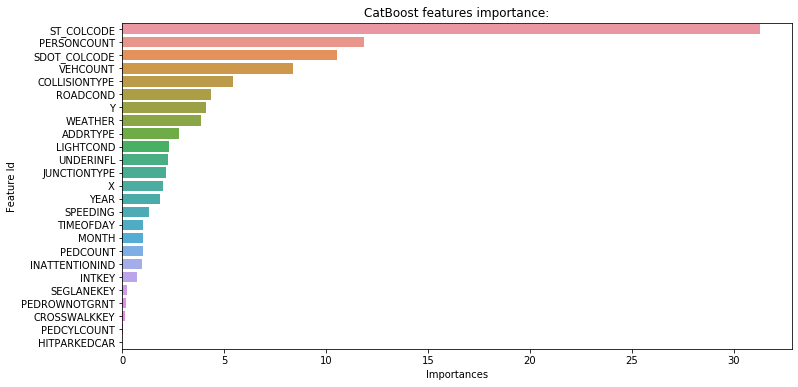

In [651]:
# feature importance
df_catboost_feature_importance = model.get_feature_importance(data=train_pool,
#                                  type='ShapValues', #type='LossFunctionChange',
                                 prettified=True,
                                 thread_count=-1,verbose=False)

plt.figure(figsize=(12, 6));
sns.barplot(x="Importances", y="Feature Id", data=df_catboost_feature_importance);
plt.title('CatBoost features importance:');

In [652]:
# SHAP value: given a prediction value, seeking for contributions from each feature

explainer = shap.TreeExplainer(model) # insert model
shap_values = explainer.shap_values(train_pool) # insert train Pool object

# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[:100,:], X_train.iloc[:100,:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


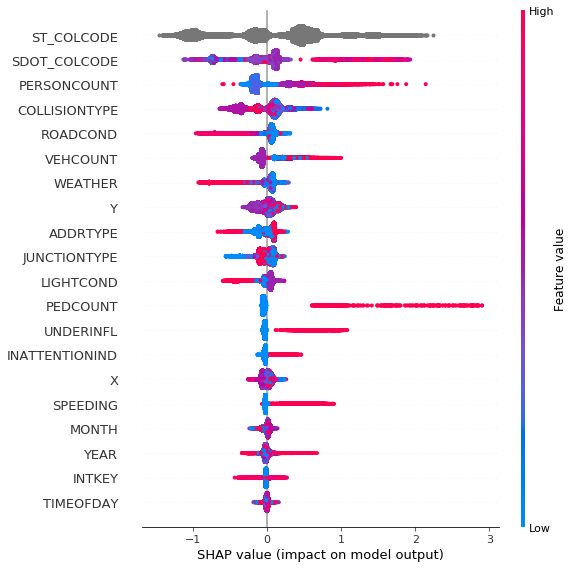

In [653]:
shap.summary_plot(shap_values, X_train)

In [266]:
# feature evaluation?
from catboost.utils import create_cd
feature_names = dict()
for column, name in enumerate(X_train):
    feature_names[column] = name
    
create_cd(
#     label=0, 
    cat_features=cat_features,
    feature_names=feature_names,
    output_path='catboost_train.cd')

!cat catboost_train.cd # column descriptors

0	Categ	COLLISIONTYPE
1	Categ	HITPARKEDCAR
2	Categ	INATTENTIONIND
3	Categ	UNDERINFL
4	Categ	SPEEDING
5	Categ	PEDROWNOTGRNT
6	Categ	WEATHER
7	Categ	ROADCOND
8	Categ	LIGHTCOND
9	Categ	SDOT_COLCODE
10	Num	X
11	Num	Y
12	Num	PERSONCOUNT
13	Num	PEDCOUNT
14	Num	PEDCYLCOUNT
15	Num	VEHCOUNT


In [271]:
# from catboost.eval.catboost_evaluation import *
# learn_params = {'iterations': 20, # 2000
#                 'learning_rate': 0.5, # we set big learning_rate,
#                                       # because we have small
#                                       # #iterations
#                 'random_seed': 0,
#                 'verbose': False,
#                 'loss_function' : 'Logloss',
#                 'boosting_type': 'Plain'}

# df_preprocessed.to_csv('catboost_train.tsv',
#     index=False, sep='\t', header=False
# )

# evaluator = CatboostEvaluation('catboost_train.tsv',
#                                fold_size=10000, # <= 50% of dataset
#                                fold_count=20,
#                                column_description='catboost_train.cd',
#                                partition_random_seed=0,
#                                #working_dir=... 
# )
# result = evaluator.eval_features(learn_config=learn_params,
#                                  eval_metrics=['Logloss', 'Accuracy'],
#                                  features_to_eval=[6, 7, 8])

# from catboost.eval.evaluation_result import *
# logloss_result = result.get_metric_results('Logloss')
# logloss_result.get_baseline_comparison(
#     ScoreConfig(ScoreType.Rel, overfit_iterations_info=False))

In [270]:
from catboost import cv

params = {'iterations':100, 'depth':6, 
          'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 200,
          'random_seed': 1234
         }
scores = cv(pool=train_pool,
            params=params, 
            fold_count=4,
            shuffle=True,
            stratified=True, # if True the folds are made by preserving the percentage of samples for each class
            plot=True
           )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7354949	best: 0.7354949 (0)	total: 222ms	remaining: 22s
99:	test: 0.7994598	best: 0.7994598 (99)	total: 13.1s	remaining: 0us
